In [74]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set_context("paper")
from matplotlib.lines import Line2D
from labellines import labelLine, labelLines

import pandas as pd

import scipy.stats
from scipy.stats import t, pearsonr

from multi_task.model_explorer import ModelExplorer
import operator

KS_NAME = "Kolmogorov-Smirnov Difference"

/tmp/ipykernel_29192/3770391633.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


# CIFAR-10

## KS Distribution plot

In [222]:
layers = range(0, 15)
networks = ["", "2", "3", "4", "5"]
df_list = []
for n in networks:
    for l in layers:
        ks_diff_path = f"wasser_dists/wasser_ks_diff_attr_hist_bettercifar10single{n}_{l}.npy"
        ks_diff = np.load(ks_diff_path, allow_pickle=True).item()
        df = pd.DataFrame.from_dict(ks_diff)
        df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: KS_NAME})
        df["Layer"] = int(l)+2
        df["Network"] = int(n) if n != "" else 1
        df = df[["Network", "Layer", "Neuron", "Class", KS_NAME]]
        df_list.append(df)
df_ks_cifar = pd.concat(df_list)
df_ks_cifar

,Network,Layer,Neuron,Class,Kolmogorov-Smirnov Difference
0,1,2,0,0,0.414763
1,1,2,0,1,-0.104255
2,1,2,0,2,-0.110735
3,1,2,0,3,0.113709
4,1,2,0,4,-0.235951
...,...,...,...,...,...
5115,5,16,511,5,0.580093
5116,5,16,511,6,-0.264001
5117,5,16,511,7,-0.493300
5118,5,16,511,8,0.634976


In [223]:
def plot_ksd_distribution(df, title_suffix='', bw=0.05):
    g = sns.violinplot(data=df, x="Layer", y=KS_NAME, bw=bw, inner=None, color="black")
    title_suffix = f" {title_suffix}" if title_suffix != '' else ''
    g.set(ylim=(-1, 1))
    g.set_title(f"{KS_NAME}{title_suffix}", fontsize='large')
    g.set(ylabel="")
    sns.despine()

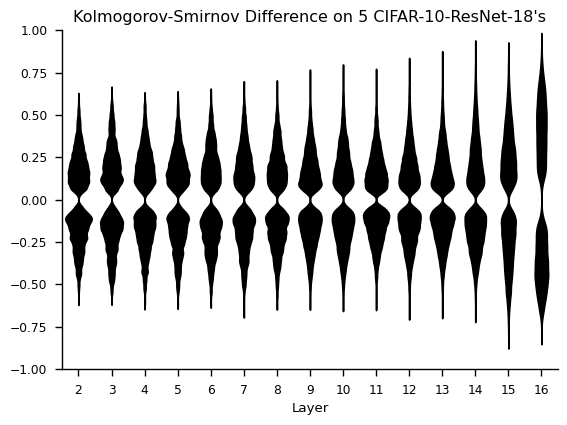

In [224]:
plot_ksd_distribution(df_ks_cifar, title_suffix="on 5 CIFAR-10-ResNet-18's")

Violins getting thinner means that the magnitude of KSD's become larger.

## Proportion plot

In [225]:
def compute_df_props(df, threshold=0.25, extra_levels=[], no_opposite_classes=True, global_proportion=True):
    # Filter with treshold
    df_proportions = df.copy()
    df_proportions[f"KS-D < {threshold}"] = df_proportions[KS_NAME] < -threshold
    df_proportions[f"KS-D > {threshold}"] = df_proportions[KS_NAME] > threshold
    
    df_proportions_counted = df_proportions.groupby(["Network", "Layer", "Neuron"]).sum()

    df_proportions_neurons_counted = df_proportions_counted.reset_index()[["Network", "Layer", "Neuron"]].groupby(["Network", "Layer"]).count().reset_index().rename(columns={"Neuron": "Neurons in layer"})

    df_prop_list = []
    for crit in ["<", ">"]:

        df_proportions_counted_crit = df_proportions_counted.copy()

        if no_opposite_classes:
            opposite_crit = '<' if crit == '>' else '>'
            valid_neurons = (df_proportions_counted_crit[f"KS-D {opposite_crit} {threshold}"] == 0)
            df_proportions_counted_crit = df_proportions_counted_crit[valid_neurons]

        df_proportions_ks_neurons_counted = df_proportions_counted_crit.reset_index()[["Network", "Layer", f"KS-D {crit} {threshold}", "Neuron"]].groupby(["Network", "Layer", f"KS-D {crit} {threshold}"]).count().reset_index().rename(columns={"Neuron": "Neurons with class count"})
        
        # add zero counts on non counted class numbers
        ns = df_proportions_ks_neurons_counted['Network'].unique()
        ls = df_proportions_ks_neurons_counted['Layer'].unique()
        ksds = df_proportions_ks_neurons_counted[f"KS-D {crit} {threshold}"].unique()

        # add extra levels
        ksds = np.unique(np.append(ksds, extra_levels)).astype(int)

        lns, lls, lksds = len(ns), len(ls), len(ksds)
        ns = ns.repeat(lls*lksds)
        ls = np.tile(ls.repeat(lksds), lns)
        ksds = np.tile(ksds, lns*lls)

        df_missing_zero_counts = pd.DataFrame({'Network': ns, 'Layer': ls, f"KS-D {crit} {threshold}": ksds})

        df_proportions_ks_neurons_counted = pd.merge(df_proportions_ks_neurons_counted, df_missing_zero_counts, on=['Network', 'Layer', f"KS-D {crit} {threshold}"], how='outer').fillna(0.0).sort_values(by=['Network', 'Layer', f"KS-D {crit} {threshold}"])

        df_counts_merged = pd.merge(df_proportions_ks_neurons_counted, df_proportions_neurons_counted, on=["Network", "Layer"])
        
        if global_proportion:
            df_counts_merged = df_counts_merged.groupby(['Layer', f"KS-D {crit} {threshold}"]).sum().reset_index()

        df_counts_merged["Proportion of neurons"] = df_counts_merged["Neurons with class count"] / df_counts_merged["Neurons in layer"]
        df_counts_merged = df_counts_merged.rename(columns={f"KS-D {crit} {threshold}": "Number of classes"})
        
        if no_opposite_classes:
            df_counts_merged["Criterion"] = f"All KS-D's {crit} {threshold}"
        else:
            df_counts_merged["Criterion"] = f"KS-D {crit} {threshold}"
        
        df_prop_list.append(df_counts_merged)

    df_props = pd.concat(df_prop_list)

    df_props["Proportion of neurons (cumsum)"] = df_props.groupby(["Network", "Layer", "Criterion"]).agg({"Proportion of neurons": 'cumsum'})
    return df_props

def plot_ksd_proportion_cifar10(df, threshold=0.25, plot_cumsum=True, no_opposite_classes=True, global_proportion=True):
    df_props = compute_df_props(df, threshold=threshold, no_opposite_classes=no_opposite_classes, global_proportion=global_proportion)

    nclasses = df_props["Number of classes"].unique()[:-1]
    nclasses.sort()

    cp = sns.color_palette("blend:#FFF,#000", len(nclasses))
    cp.append("red")
    cp.reverse()
    SO = np.sort(df_props['Criterion'].unique())[::-1]

    y = "Proportion of neurons (cumsum)" if plot_cumsum else "Proportion of neurons"
    loc = "lower center" if plot_cumsum else "upper center"

    ylabel = "Proportion of neurons with $\\leq n$ classes\nfulfilling the criterion" if plot_cumsum else "Proportion of neurons with exactly $n$ classes\nfulfilling the criterion"

    if no_opposite_classes:
        nclasses = [1, 2]

    for n in nclasses:
        sns.lineplot(data=df_props[df_props["Number of classes"] == n], x="Layer", y=y, style="Criterion", style_order=SO, errorbar=None, color=cp[n], label=f"{n}", legend=False)
    l = plt.gca().get_lines()

    if no_opposite_classes:
        # xvals = [4.5, 8.5, 6.2, 4.5]
        xvals = [12.5, 12.5, 12.5, 12.5]
        yoffsets = 0
    else:
        xvals = [15.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 15.5, 0.0, 16.0, 0.0] if plot_cumsum else [2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.6, 2.0, 0.0, 14.5, 0.0, 15.5, 0.0]
        yoffsets = 0

    xvals_cleared = []
    for (i, x) in enumerate(xvals):
        if x == 0:
            l[i].set_label("")
        else:
            xvals_cleared.append(x)
    labelLines(l, align=False, xvals=xvals_cleared, yoffsets=yoffsets);
    
    custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
                    Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
                    ]
    plt.gca().legend(custom_lines, SO, ncols=2, loc=loc, frameon=False, title="Criterion")
    plt.gca().set(ylabel='')
    plt.gca().set_title(ylabel, fontsize='large')
    sns.despine()

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.159375),(2,0.159375),...,(16,0.00078125)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.4375),(2,0.4375),...,(16,0.0078125)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.8),(2,0.8),...,(16,0.0546875)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D((2,0.996875),(2,0.996875),...,(16,0.294922)), but could not find a label for it.
  warnings.warn(
/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packag

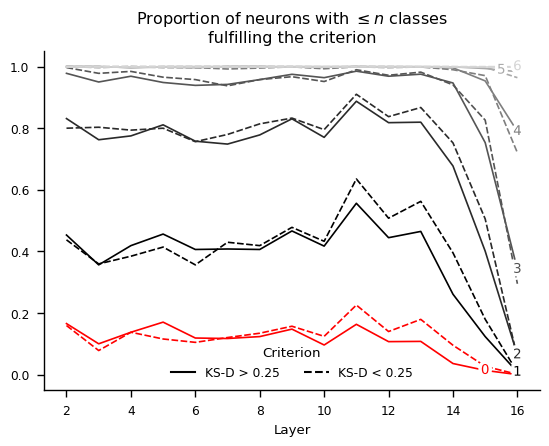

In [226]:
# This is ignoring if there are some classes at that neuron with the opposite KS-D direction.
plot_ksd_proportion_cifar10(df_ks_cifar, no_opposite_classes=False)

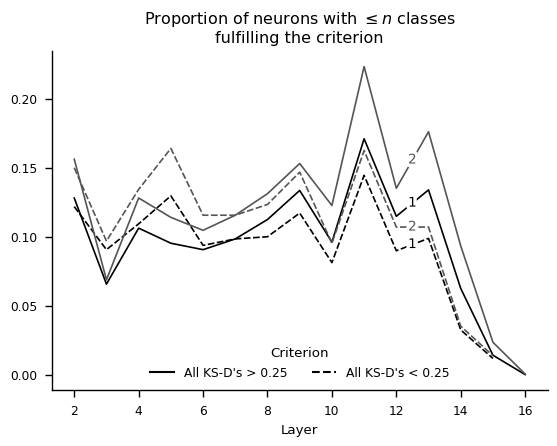

In [227]:
# This considers only neurons where there is no class with the opposite KS-D direction.
plot_ksd_proportion_cifar10(df_ks_cifar, no_opposite_classes=True)
# this ignores n = 3 and n = 4 as barely any change.

## Outline histogram plot

In [228]:
acts_5_103 = np.load("attr_hist_cifar_for_paper/acts_5_103ks_diff.npy", allow_pickle=True).item()
df_acts_5_103 = pd.DataFrame(acts_5_103)

df_list = []
for c in df_acts_5_103.columns:
    for r in df_acts_5_103.index:
        acts = pd.Series(df_acts_5_103[c][r])
        df = pd.DataFrame(data={"Activations": acts, "Class": c, "Type": r})
        df_list.append(df)
df_acts_5_103 = pd.concat(df_list)

In [229]:
df_acts_5_103

,Activations,Class,Type
0,0.102734,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
1,0.098903,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
2,0.089662,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
3,0.094284,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
4,0.223361,Class: Airplane\nKolmogorov-Smirnov Diff.: -0.40,Out-of-class
...,...,...,...
1010,0.134426,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class
1011,0.167308,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class
1012,0.099572,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class
1013,0.229609,Class: Truck\nKolmogorov-Smirnov Diff.: -0.31,In-class


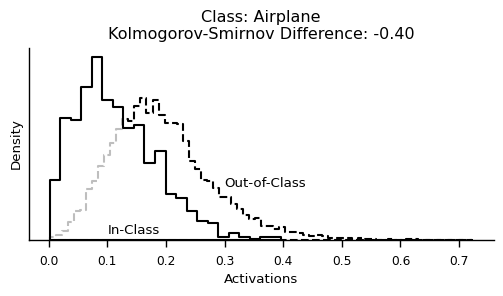

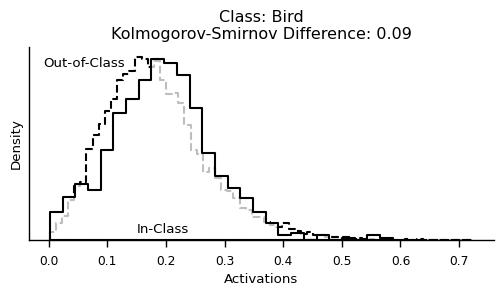

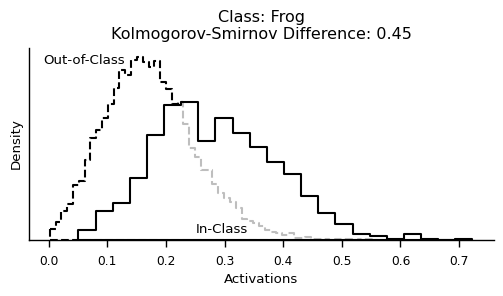

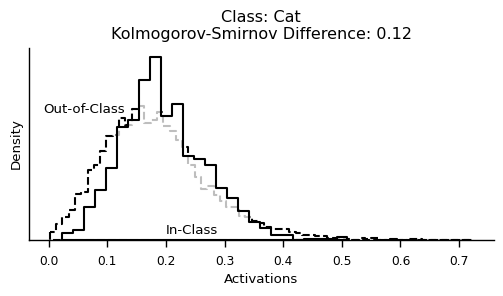

In [230]:
label_positions = {
    "Airplane": ((0.1, 0.25), (0.3, 2.0)),
    "Bird": ((0.15, 0.2), (-0.01, 4.8)),
    "Frog": ((0.25, 0.2), (-0.01, 5.1)),
    "Cat": ((0.2, 0.25), (-0.01, 4.8)),
}

for c in ["Airplane", "Bird", "Frog", "Cat"]:
    df_data = df_acts_5_103[df_acts_5_103["Class"].str.contains(c)]

    linestyles = ["--", "-"]
    f, ax = plt.subplots(figsize=(6, 2.5))
    for (i, t) in enumerate(df_data["Type"].unique()):
        df_data_type = df_data[df_data["Type"] == t]
        sns.histplot(ax=ax, data=df_data_type, x="Activations", color="white", element="step", fill=True, linestyle=linestyles[i], label=t, stat="density", edgecolor="black", linewidth=1.5)
    p = plt.gca()
    p.annotate("In-Class", (0.0, 0.0), label_positions[c][0], fontsize="medium");
    p.annotate("Out-of-Class", (0.0, 0.0), label_positions[c][1], fontsize="medium");
    p.set(yticklabels=[], yticks=[])
    p.set_title(df_data["Class"][0].to_list()[0].replace("Diff.", "Difference"), fontsize='large')
    # p.text(*label_positions[c][2], df_data["Class"][0].to_list()[0], fontsize="large");
    sns.despine()
    plt.show()

## Gradient correlation plot

In [231]:
networks = ["", "2", "3", "4", "5"]
df_list = []
for n in networks:
    df_j_cifar = pd.read_pickle(f"local_storage/grads_bettercifar10single{n}_afterrelu_val_all_samples.pkl")
    df_j_cifar = df_j_cifar.melt(id_vars=["layer_name", "neuron_idx"], var_name="Class", value_name="Avg. Jacobian").rename(columns={"layer_name": "Layer", "neuron_idx": "Neuron"})

    k = df_j_cifar["Layer"].unique()
    v = np.arange(len(df_j_cifar["Layer"].unique()))+2
    ln_map = {k_:v_ for k_, v_ in zip(k, v)}

    df_j_cifar["Layer"] = df_j_cifar["Layer"].map(ln_map)
    df_j_cifar["Network"] = int(n) if n != "" else 1

    df_j_cifar = df_j_cifar[["Network", "Layer", "Neuron", "Class", "Avg. Jacobian"]]

    df_list.append(df_j_cifar)

df_j_cifar = pd.concat(df_list)

In [241]:
df_corr_whole_layer = pd.merge(df_ks_cifar, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Network', 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer["Criterion"] = "All KS-D's"

In [242]:
df_ks_cifar_pos = df_ks_cifar[df_ks_cifar[KS_NAME] >= 0]
df_ks_cifar_neg = df_ks_cifar[df_ks_cifar[KS_NAME] <= 0]

df_corr_whole_layer_ks_pos = pd.merge(df_ks_cifar_pos, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Network', 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_ks_pos['Criterion'] = "KS-D's $\\geq 0$"

df_corr_whole_layer_ks_neg = pd.merge(df_ks_cifar_neg, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Network', 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_ks_neg['Criterion'] = "KS-D's $\\leq 0$"

In [254]:
df_corr_whole_all = pd.concat([df_corr_whole_layer, df_corr_whole_layer_ks_pos, df_corr_whole_layer_ks_neg])

In [255]:
# Critical values for the correlation
def r_crit_abs(n, p=0.05):
    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    r_crit_abs = -dist.ppf(p/2)
    return r_crit_abs

In [256]:
df_r_crit = pd.merge(df_ks_cifar, df_j_cifar, on=["Network", "Layer", 'Neuron', "Class"]).groupby(["Layer"]).count()['Neuron'].reset_index().rename(columns={'Neuron': 'n'})
df_r_crit['Correlation KS-D with Avg. Jac.'] = df_r_crit['n'].apply(lambda n: r_crit_abs(n))
df_r_crit['Criterion'] = 'Non-significant region at $\\alpha = 0.05$'
df_r_crit = df_r_crit.drop(columns=['n'])
df_r_crit

df_r_crit_neg = df_r_crit.copy()
df_r_crit_neg['Criterion'] = ''
df_r_crit_neg['Correlation KS-D with Avg. Jac.'] = -df_r_crit_neg['Correlation KS-D with Avg. Jac.']

In [257]:
df_corr_whole_all = df_corr_whole_all.drop(columns=['level_1'])
df_corr_whole_all = pd.concat([df_corr_whole_all, df_r_crit, df_r_crit_neg])

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child8), but could not find a label for it.
  warnings.warn(


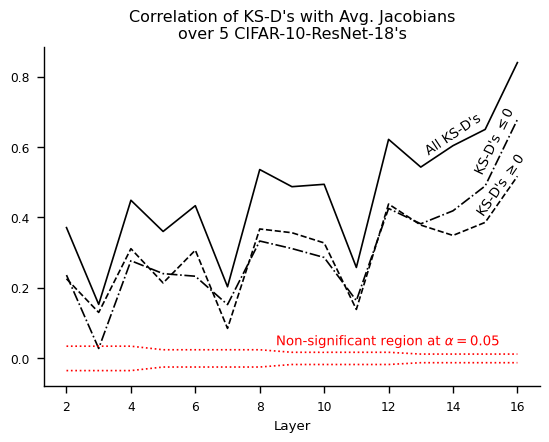

In [290]:
crits = df_corr_whole_all['Criterion'].unique()
styles = ['solid', 'dashed', 'dashdot', 'dotted', 'dotted']
colors = ['black', 'black', 'black', 'red', 'red']

for c, s, col in zip(crits, styles, colors):
    sns.lineplot(data=df_corr_whole_all[df_corr_whole_all['Criterion'] == c], x='Layer', y='Correlation KS-D with Avg. Jac.', linestyle=s, color=col, legend=False, label=c)
l = plt.gca().get_lines()

# df_r_crit_fb = df_corr_whole_all[(df_corr_whole_all['Criterion'].str.contains('Critical')) & (df_corr_whole_all['Network'] == 1)]
# plt.gca().fill_between(df_r_crit_fb['Layer'], -df_r_crit_fb['Correlation KS-D with Avg. Jac.'], df_r_crit_fb['Correlation KS-D with Avg. Jac.'], label='Region')

labelLines(l, align=[True, True, True, False], xvals=[14, 15.5, 15.3, 12], yoffsets=[0.03, 0.04, 0.07, 0.03]);
# custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[2].get_linestyle()),
#                 ]
# plt.gca().legend(custom_lines, crits, ncols=2, loc=loc, frameon=False, title="Criterion")
plt.gca().set(ylabel='')
plt.gca().set_title("Correlation of KS-D's with Avg. Jacobians\nover 5 CIFAR-10-ResNet-18's", fontsize='large')
sns.despine()


In [187]:
# DONE: Check if the last layer gradient correlation is similar to the last layer weight correlation
#   single-head cifar
save_model_path = r'/mnt/raid/data/chebykin/saved_models/14_33_on_September_16/optimizer=SGD|batch_size=128|lr=0.1|connectivities_lr=0.0|chunks=[64|_64|_64|_128|_128|_128|_128|_256|_256|_256|_256|_512|_512|_512|_512]|architecture=binmatr2_resnet18|width_mul=1|weight_decay=0.000_240_model.pkl'
param_file = 'params/binmatr2_cifar_sgd1bias_fc_batch128_weightdecay3e-4_singletask.json'

me_cifar = ModelExplorer(save_model_path, param_file, model_to_use='my')

n_used_conns = 2
n_used_conns = 6
n_used_conns = 10
n_used_conns = 14
assume problem where cifar networks ignored the enable_bias parameter
n_used_conns = 2
n_used_conns = 6
n_used_conns = 10
n_used_conns = 14


In [225]:
neuron = 12
llw = me_cifar.model['all'].linear.weight.T[neuron, :].cpu().detach().numpy()
jacs = df_j_cifar[(df_j_cifar['Network'] == 1) & (df_j_cifar['Layer'] == 16) & (df_j_cifar['Neuron'] == neuron)]['Avg. Jacobian'].to_numpy()
np.corrcoef(llw, jacs)

array([[1., 1.],
       [1., 1.]])

## Gradient correlation plot (no skip connections)

In [291]:
layers = range(0, 15)
networks = ["", "2", "3", "4", "5"]
df_list = []
for n in networks:
    for l in layers:
        ks_diff_path = f"wasser_dists/wasser_ks_diff_attr_hist_bettercifar10single{n}_noskip_{l}.npy"
        ks_diff = np.load(ks_diff_path, allow_pickle=True).item()
        df = pd.DataFrame.from_dict(ks_diff)
        df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: KS_NAME})
        df["Layer"] = int(l)+2
        df["Network"] = int(n) if n != "" else 1
        df = df[["Network", "Layer", "Neuron", "Class", KS_NAME]]
        df_list.append(df)
df_ks_cifar_noskip = pd.concat(df_list)

networks = ["", "2", "3", "4", "5"]
df_list = []
for n in networks:
    df_j_cifar_noskip = pd.read_pickle(f"local_storage/grads_bettercifar10single{n}_noskip_afterrelu_val_all_samples.pkl")
    df_j_cifar_noskip = df_j_cifar_noskip.melt(id_vars=["layer_name", "neuron_idx"], var_name="Class", value_name="Avg. Jacobian").rename(columns={"layer_name": "Layer", "neuron_idx": "Neuron"})

    k = df_j_cifar_noskip["Layer"].unique()
    v = np.arange(len(df_j_cifar_noskip["Layer"].unique()))+2
    ln_map = {k_:v_ for k_, v_ in zip(k, v)}

    df_j_cifar_noskip["Layer"] = df_j_cifar_noskip["Layer"].map(ln_map)
    df_j_cifar_noskip["Network"] = int(n) if n != "" else 1

    df_j_cifar_noskip = df_j_cifar_noskip[["Network", "Layer", "Neuron", "Class", "Avg. Jacobian"]]

    df_list.append(df_j_cifar_noskip)

df_j_cifar_noskip = pd.concat(df_list)

df_ks_cifar_noskip, df_j_cifar_noskip

(      Network  Layer  Neuron  Class  Kolmogorov-Smirnov Difference
 0           1      2       0      0                      -0.452013
 1           1      2       0      1                       0.258342
 2           1      2       0      2                      -0.261190
 3           1      2       0      3                       0.177077
 4           1      2       0      4                      -0.242220
 ...       ...    ...     ...    ...                            ...
 5115        5     16     511      5                      -0.548639
 5116        5     16     511      6                       0.325902
 5117        5     16     511      7                       0.404624
 5118        5     16     511      8                       0.566273
 5119        5     16     511      9                       0.820947
 
 [188800 rows x 5 columns],
        Network  Layer  Neuron Class  Avg. Jacobian
 0            1      2       0     0      -0.000633
 1            1      2       1     0       0.00041

In [295]:
df_corr_whole_layer_noskip = pd.merge(df_ks_cifar_noskip, df_j_cifar_noskip, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Network', 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_noskip["Criterion"] = "All KS-D's"

df_ks_cifar_noskip_pos = df_ks_cifar_noskip[df_ks_cifar_noskip[KS_NAME] >= 0]
df_ks_cifar_noskip_neg = df_ks_cifar_noskip[df_ks_cifar_noskip[KS_NAME] <= 0]

df_corr_whole_layer_noskip_ks_pos = pd.merge(df_ks_cifar_noskip_pos, df_j_cifar_noskip, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=["Network", 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_noskip_ks_pos['Criterion'] = "KS-D's $\\geq 0$"

df_corr_whole_layer_noskip_ks_neg = pd.merge(df_ks_cifar_noskip_neg, df_j_cifar_noskip, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=["Network", 'Neuron', 'Class']).groupby(["Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_noskip_ks_neg['Criterion'] = "KS-D's $\\leq 0$"

df_corr_whole_all_noskip = pd.concat([df_corr_whole_layer_noskip, df_corr_whole_layer_noskip_ks_pos, df_corr_whole_layer_noskip_ks_neg])

# Critical values for the correlation
def r_crit_abs(n, p=0.05):
    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    r_crit_abs = -dist.ppf(p/2)
    return r_crit_abs

df_r_crit_noskip = pd.merge(df_ks_cifar_noskip, df_j_cifar_noskip, on=["Network", "Layer", 'Neuron', "Class"]).groupby(["Layer"]).count()['Neuron'].reset_index().rename(columns={'Neuron': 'n'})
df_r_crit_noskip['Correlation KS-D with Avg. Jac.'] = df_r_crit_noskip['n'].apply(lambda n: r_crit_abs(n))
df_r_crit_noskip['Criterion'] = 'Non-significant region at $\\alpha = 0.05$'
df_r_crit_noskip = df_r_crit_noskip.drop(columns=['n'])

df_r_crit_noskip_neg = df_r_crit_noskip.copy()
df_r_crit_noskip_neg['Criterion'] = ''
df_r_crit_noskip_neg['Correlation KS-D with Avg. Jac.'] = -df_r_crit_noskip_neg['Correlation KS-D with Avg. Jac.']

df_corr_whole_all_noskip = df_corr_whole_all_noskip.drop(columns=['level_1'])
df_corr_whole_all_noskip = pd.concat([df_corr_whole_all_noskip, df_r_crit_noskip, df_r_crit_noskip_neg])

/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child8), but could not find a label for it.
  warnings.warn(


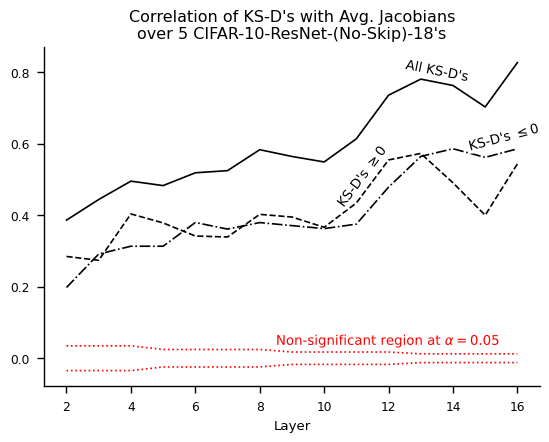

In [355]:
crits = df_corr_whole_all_noskip['Criterion'].unique()
styles = ['solid', 'dashed', 'dashdot', 'dotted', 'dotted']
colors = ['black', 'black', 'black', 'red', 'red']

for c, s, col in zip(crits, styles, colors):
    sns.lineplot(data=df_corr_whole_all_noskip[df_corr_whole_all_noskip['Criterion'] == c], x='Layer', y='Correlation KS-D with Avg. Jac.', linestyle=s, color=col, err_kws={'alpha': 0.05}, legend=False, label=c)
l = plt.gca().get_lines()

# df_r_crit_fb = df_corr_whole_all_noskip[(df_corr_whole_all_noskip['Criterion'].str.contains('Critical')) & (df_corr_whole_all_noskip['Network'] == 1)]
# plt.gca().fill_between(df_r_crit_fb['Layer'], -df_r_crit_fb['Correlation KS-D with Avg. Jac.'], df_r_crit_fb['Correlation KS-D with Avg. Jac.'], label='Region')

labelLines(l, align=[True, True, False, False], xvals=[13.5, 11.2, 15.6, 12.0], yoffsets=[0.03, 0.05, 0.04, 0.03]);
# custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[2].get_linestyle()),
#                 ]
# plt.gca().legend(custom_lines, crits, ncols=2, loc=loc, frameon=False, title="Criterion")
plt.gca().set(ylabel='')
plt.gca().set_title("Correlation of KS-D's with Avg. Jacobians\nover 5 CIFAR-10-ResNet-(No-Skip)-18's", fontsize='large')
sns.despine()

## Bin. sep over layers plot

In [218]:
layers = range(15)
df_list = []
for model in ['', 2, 3, 4, 5]:
    for li in layers:
        df = pd.read_csv(f"binary_separability_bettercifar10single{model}_nonsparse_afterrelu_{li}.csv").rename(columns={"layer_name": "Layer", "neuron_idx": "Neuron", "class_idx": "Class", 'mean_balanced_acc': 'meanBA'})
        df['Network'] = 1 if model == '' else model
        df = df[['Network', 'Layer', 'Neuron', 'Class', 'meanBA']]
        df_list.append(df)
df_bin_sep_cifar = pd.concat(df_list)
k = df_bin_sep_cifar["Layer"].unique()
v = np.arange(len(df_bin_sep_cifar["Layer"].unique()))+2
ln_map = {k_:v_ for k_, v_ in zip(k, v)}

df_bin_sep_cifar["Layer"] = df_bin_sep_cifar["Layer"].map(ln_map)
df_bin_sep_cifar

(      Network  Layer  Neuron  Class  Kolmogorov-Smirnov Difference
 0           1      2       0      0                      -0.452013
 1           1      2       0      1                       0.258342
 2           1      2       0      2                      -0.261190
 3           1      2       0      3                       0.177077
 4           1      2       0      4                      -0.242220
 ...       ...    ...     ...    ...                            ...
 5115        5     16     511      5                      -0.548639
 5116        5     16     511      6                       0.325902
 5117        5     16     511      7                       0.404624
 5118        5     16     511      8                       0.566273
 5119        5     16     511      9                       0.820947
 
 [188800 rows x 5 columns],
       Network  Layer  Neuron  Class    meanBA
 0           1      2       0      0  0.701728
 1           1      2       0      1  0.519982
 2           

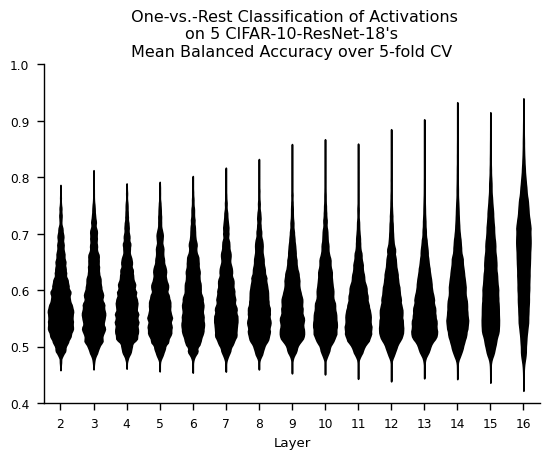

In [156]:
df = df_bin_sep_cifar
bw = 0.05
title_suffix = "One-vs.-Rest Classification of Activations\non 5 CIFAR-10-ResNet-18's\nMean Balanced Accuracy over 5-fold CV"

g = sns.violinplot(data=df, x="Layer", y='meanBA', bw=bw, inner=None, color="black")
title_suffix = f" {title_suffix}" if title_suffix != '' else ''
g.set(ylim=(0.4, 1))
g.set_title(f"{title_suffix}", fontsize='large')
g.set(ylabel="")
sns.despine()

#TODO: is there a difference in magnitude between positive and negative KD-D's?

In [169]:
df_merged_ks_bin_sep_cifar = pd.merge(df_ks_cifar, df_bin_sep_cifar, on=['Network', 'Layer', 'Neuron', 'Class'])
# df_merged_ks_bin_sep_cifar.loc[df_merged_ks_bin_sep_cifar[KS_NAME] <= 0]['Criterion'] = '<= 0'
df_merged_ks_bin_sep_cifar['Criterion'] = df_merged_ks_bin_sep_cifar[KS_NAME].apply(lambda x: "KS-D's $\\leq 0$" if x <= 0 else "KS-D's $\\geq 0$")
df_merged_ks_bin_sep_cifar

,Network,Layer,Neuron,Class,Kolmogorov-Smirnov Difference,meanBA,Criterion
0,1,2,0,0,0.414763,0.701728,KS-D's $\geq 0$
1,1,2,0,1,-0.104255,0.519982,KS-D's $\leq 0$
2,1,2,0,2,-0.110735,0.539045,KS-D's $\leq 0$
3,1,2,0,3,0.113709,0.494956,KS-D's $\geq 0$
4,1,2,0,4,-0.235951,0.610172,KS-D's $\leq 0$
...,...,...,...,...,...,...,...
188795,5,16,511,5,0.580093,0.646552,KS-D's $\geq 0$
188796,5,16,511,6,-0.264001,0.600088,KS-D's $\leq 0$
188797,5,16,511,7,-0.493300,0.722987,KS-D's $\leq 0$
188798,5,16,511,8,0.634976,0.753816,KS-D's $\geq 0$


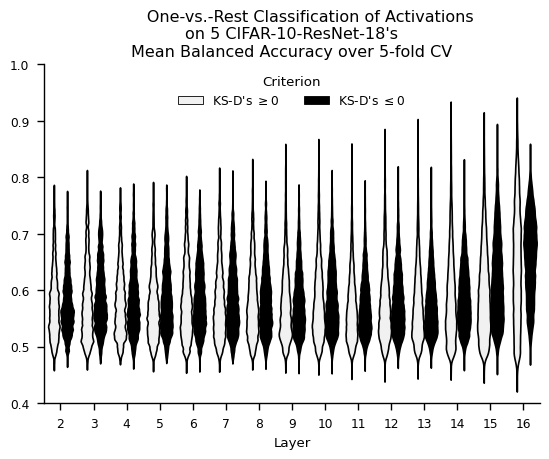

In [175]:
g = sns.violinplot(data=df_merged_ks_bin_sep_cifar, x="Layer", y='meanBA', hue='Criterion', bw=bw, inner=None, color="black")
title_suffix = f" {title_suffix}" if title_suffix != '' else ''
g.set(ylim=(0.4, 1))
g.set_title(f"{title_suffix}", fontsize='large')
g.set(ylabel="")
g.legend(loc='upper center', title='Criterion', frameon=False, ncol=2)
sns.despine()

### Correlations with KS-D's

In [35]:
# no overall because of signs
np.corrcoef(df_ks_cifar[KS_NAME], df_bin_sep_cifar['meanBA'])

array([[1.        , 0.01095267],
       [0.01095267, 1.        ]])

In [47]:
np.corrcoef(df_ks_cifar[df_ks_cifar[KS_NAME] > 0][KS_NAME], df_bin_sep_cifar[df_ks_cifar[KS_NAME] > 0]['meanBA']), np.corrcoef(df_ks_cifar[df_ks_cifar[KS_NAME] < 0][KS_NAME], df_bin_sep_cifar[df_ks_cifar[KS_NAME] < 0]['meanBA'])

(array([[1.        , 0.94627006],
        [0.94627006, 1.        ]]),
 array([[ 1.        , -0.97100554],
        [-0.97100554,  1.        ]]))

In [141]:
df_list = []
for crit_name, crit_op in [('\\geq', operator.ge), ('\\leq', operator.le), ('!=', operator.ne)]:
    df_ks_cifar_crit = df_ks_cifar[crit_op(df_ks_cifar[KS_NAME], 0)]
    df_ks_cifar_crit[f"{KS_NAME}_abs"] = df_ks_cifar_crit[KS_NAME].abs()
    df_corr_crit = pd.merge(df_ks_cifar_crit, df_bin_sep_cifar, on=['Network', 'Layer', 'Neuron', 'Class']).sort_values(by=['Network', 'Neuron', 'Class']).groupby(['Layer'])[[f"{KS_NAME}_abs", 'meanBA']].corr()

    df_corr_crit = df_corr_crit.reset_index().iloc[:, ::2].iloc[1::2][['Layer', f"{KS_NAME}_abs"]].rename(columns={f"{KS_NAME}_abs": "Correlation KS-D's and mean BA"})
    if crit_name == '!=':
        df_corr_crit['Criterion'] = f"All KS-D's\n(abs. vals.)"
    else:
        df_corr_crit['Criterion'] = f"KS-D's ${crit_name} 0$"
    df_list.append(df_corr_crit)
df_corrs_all = pd.concat(df_list).reset_index(drop=True)

/tmp/ipykernel_29192/2223990407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ks_cifar_crit[f"{KS_NAME}_abs"] = df_ks_cifar_crit[KS_NAME].abs()
/tmp/ipykernel_29192/2223990407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ks_cifar_crit[f"{KS_NAME}_abs"] = df_ks_cifar_crit[KS_NAME].abs()


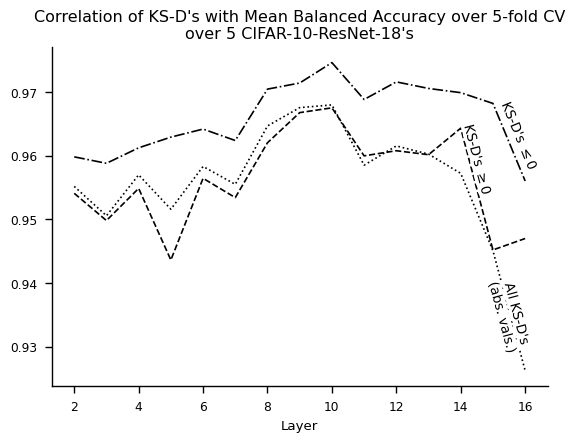

In [148]:
styles = ['dashed', 'dashdot', 'dotted']

for crit, style in zip(df_corrs_all['Criterion'].unique(), styles):
    sns.lineplot(data=df_corrs_all[df_corrs_all['Criterion'] == crit], x='Layer', y="Correlation KS-D's and mean BA", linestyle=style, color='black', label=crit, legend=False)
l = plt.gca().get_lines()

labelLines(l, xvals=[14.5, 15.8, 15.5], yoffsets=[0.0045, 0.0045, -0.0008]);
plt.gca().set(ylabel='')
plt.gca().set_title("Correlation of KS-D's with Mean Balanced Accuracy over 5-fold CV\nover 5 CIFAR-10-ResNet-18's", fontsize='large')
sns.despine()

In [213]:
# DONE: check wasser shifts again.. -> less, wasser dists were better but worse than KS-Diff.
SHIFTS_NAME = "Mean Shift"

layers = range(0, 15)
networks = ["", "2", "3", "4", "5"]
# networks = [""]
df_list = []
for n in networks:
    for l in layers:
        shifts_path = f"wasser_dists/wasser_dist_attr_hist_bettercifar10single{n}_{l}.npy"
        shifts = np.load(shifts_path, allow_pickle=True).item()
        df = pd.DataFrame.from_dict(shifts)
        df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: SHIFTS_NAME})
        df["Layer"] = int(l)+2
        df["Network"] = int(n) if n != "" else 1
        df = df[["Network", "Layer", "Neuron", "Class", SHIFTS_NAME]]
        df_list.append(df)
df_shifts_cifar = pd.concat(df_list)
df_shifts_cifar

,Network,Layer,Neuron,Class,Mean Shift
0,1,2,0,0,0.147317
1,1,2,0,1,-0.035813
2,1,2,0,2,-0.027573
3,1,2,0,3,0.030021
4,1,2,0,4,-0.067708
...,...,...,...,...,...
5115,5,16,511,5,0.140038
5116,5,16,511,6,-0.083826
5117,5,16,511,7,-0.129402
5118,5,16,511,8,0.214113


In [215]:
# no overall because of signs
df_bin_sep_cifar_only_one = df_bin_sep_cifar#[df_bin_sep_cifar['Network'] == 1]

np.corrcoef(df_shifts_cifar[SHIFTS_NAME], df_bin_sep_cifar_only_one['meanBA']), np.corrcoef(df_shifts_cifar[df_shifts_cifar[SHIFTS_NAME] > 0][SHIFTS_NAME], df_bin_sep_cifar_only_one[df_shifts_cifar[SHIFTS_NAME] > 0]['meanBA']), np.corrcoef(df_shifts_cifar[df_shifts_cifar[SHIFTS_NAME] < 0][SHIFTS_NAME], df_bin_sep_cifar_only_one[df_shifts_cifar[SHIFTS_NAME] < 0]['meanBA'])

(array([[1.        , 0.15589457],
        [0.15589457, 1.        ]]),
 array([[1.        , 0.94629442],
        [0.94629442, 1.        ]]),
 array([[ 1.        , -0.91304772],
        [-0.91304772,  1.        ]]))

# Imagenet

## KS Distribution plot

In [356]:
layers = range(0, 15)
df_list = []
for l in layers:
    ks_diff_path = f"wasser_dists/wasser_ks_diff_attr_hist_pretrained_imagenet_afterrelu_{l}.npy"
    ks_diff = np.load(ks_diff_path, allow_pickle=True).item()
    df = pd.DataFrame.from_dict(ks_diff)
    df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: KS_NAME})
    df["Layer"] = int(l)+2
    df["Network"] = 1
    df = df[["Network", "Layer", "Neuron", "Class", KS_NAME]]
    df_list.append(df)
df_ks_imagenet = pd.concat(df_list)
df_ks_imagenet

,Network,Layer,Neuron,Class,Kolmogorov-Smirnov Difference
0,1,2,0,0,0.339037
1,1,2,0,1,-0.235088
2,1,2,0,2,-0.243744
3,1,2,0,3,-0.340359
4,1,2,0,4,-0.183776
...,...,...,...,...,...
511995,1,16,511,995,-0.266546
511996,1,16,511,996,-0.292712
511997,1,16,511,997,-0.179515
511998,1,16,511,998,-0.170451


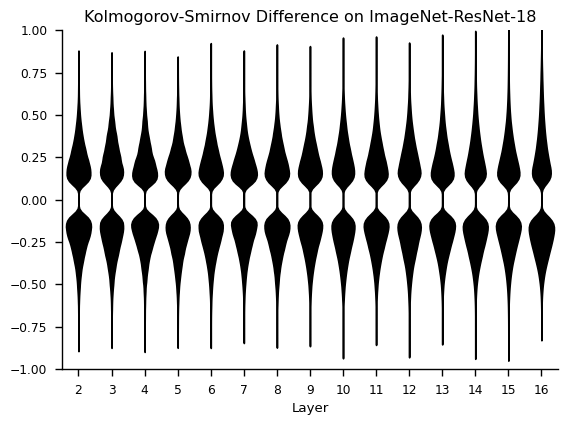

In [357]:
plot_ksd_distribution(df_ks_imagenet, title_suffix="on ImageNet-ResNet-18")

## KSD Proportion Plot

In [54]:
def plot_ksd_proportion_imagenet(df, threshold=0.25, plot_cumsum=True, extra_levels=[80, 120, 150, 170, 200, 300]):
    df_props = compute_df_props(df, threshold=threshold, extra_levels=extra_levels)

    nclasses = df_props["Number of classes"].unique()[:-1]
    nclasses.sort()
    # return nclasses

    SO = [f"KS-D > {threshold}", f"KS-D < {threshold}"]

    y = "Proportion of neurons (cumsum)" if plot_cumsum else "Proportion of neurons"
    loc = "upper right" if plot_cumsum else "upper center"

    ylabel = "Proportion of neurons with $\\leq n$ classes\nfulfilling the criterion" if plot_cumsum else "Proportion of neurons with exactly $n$ classes\nfulfilling the criterion"

    # xvals= [15.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 16.0, 0.0, 15.5, 0.0, 16.0, 0.0] if plot_cumsum else [2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.6, 2.0, 0.0, 14.5, 0.0, 15.5, 0.0]

    # df_props = df_props[df_props['Criterion'] == SO[0]]

    if len(extra_levels) == 0:
        nclasses_it = nclasses
        c_it = nclasses

        cp = sns.color_palette("blend:#FFF,#000", nclasses[-1]+1)
        cp.append("red")
        cp.reverse()
    else:
        nclasses_it = extra_levels
        c_it = np.arange(len(nclasses_it))

        cp = sns.color_palette("blend:#FFF,#000", len(nclasses_it)+2)
        if extra_levels[0] == 0:
            cp.append("red")
        cp.reverse()

    for n, ci in zip(nclasses_it, c_it):
        sns.lineplot(data=df_props[df_props["Number of classes"] == n], x="Layer", y=y, style="Criterion", style_order=SO, errorbar=None, color=cp[ci], label=f"{n}", legend=False)
    l = plt.gca().get_lines()

    # xvals_cleared = []
    # for (i, x) in enumerate(xvals):
    #     if x == 0:
    #         l[i].set_label("")
    #     else:
    #         xvals_cleared.append(x)

    labelLines(l, align=False)#, xvals=xvals_cleared);
    custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
                    Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
                    ]
    plt.gca().legend(custom_lines, SO, ncols=2, loc=loc, frameon=False, title="Criterion", bbox_to_anchor=(1, 0.85))
    plt.gca().set(ylabel=ylabel)
    sns.despine()

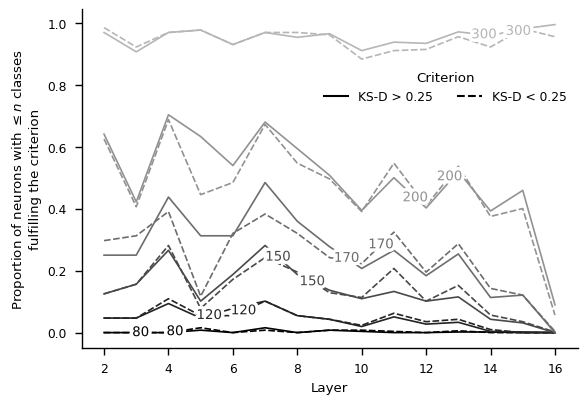

In [55]:
plot_ksd_proportion_imagenet(df_ks_imagenet)

## Gradient correlation plot

In [358]:
df_j_imagenet = pd.read_pickle("local_storage/grads_pretrained_imagenet_afterrelu_val_all_samples.pkl")
df_j_imagenet = df_j_imagenet.melt(id_vars=["layer_name", "neuron_idx"], var_name="Class", value_name="Avg. Jacobian").rename(columns={"layer_name": "Layer", "neuron_idx": "Neuron"})

k = df_j_imagenet["Layer"].unique()
v = np.arange(len(df_j_imagenet["Layer"].unique()))+2
ln_map = {k_:v_ for k_, v_ in zip(k, v)}

df_j_imagenet["Layer"] = df_j_imagenet["Layer"].map(ln_map)
df_j_imagenet["Network"] = 1

df_j_imagenet = df_j_imagenet[["Network", "Layer", "Neuron", "Class", "Avg. Jacobian"]]
df_j_imagenet, k

(         Network  Layer  Neuron Class  Avg. Jacobian
 0              1      2       0     0      -0.000151
 1              1      2       1     0       0.000007
 2              1      2       2     0       0.000014
 3              1      2       3     0      -0.000011
 4              1      2       4     0       0.000061
 ...          ...    ...     ...   ...            ...
 3775995        1     16     507   999       0.000295
 3775996        1     16     508   999       0.002074
 3775997        1     16     509   999       0.000852
 3775998        1     16     510   999      -0.001021
 3775999        1     16     511   999       0.001354
 
 [3776000 rows x 5 columns],
 array(['layer1.0', 'layer1.1.relu1', 'layer1.1', 'layer2.0.relu1',
        'layer2.0', 'layer2.1.relu1', 'layer2.1', 'layer3.0.relu1',
        'layer3.0', 'layer3.1.relu1', 'layer3.1', 'layer4.0.relu1',
        'layer4.0', 'layer4.1.relu1', 'layer4.1'], dtype=object))

In [359]:
df_corr_imagenet = pd.merge(df_ks_imagenet, df_j_imagenet, on=["Network", "Layer", "Neuron", "Class"]).groupby(["Network", "Layer", "Neuron"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})

In [360]:
df_corr_whole_layer_imagenet = pd.merge(df_ks_imagenet, df_j_imagenet, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Neuron', 'Class']).groupby(["Network", "Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_imagenet["Criterion"] = "All KS-D's"

df_ks_imagenet_pos = df_ks_imagenet[df_ks_imagenet[KS_NAME] >= 0]
df_ks_imagenet_neg = df_ks_imagenet[df_ks_imagenet[KS_NAME] <= 0]

df_corr_whole_layer_imagenet_ks_pos = pd.merge(df_ks_imagenet_pos, df_j_imagenet, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Neuron', 'Class']).groupby(["Network", "Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_imagenet_ks_pos['Criterion'] = "KS-D's $\\geq 0$"

df_corr_whole_layer_imagenet_ks_neg = pd.merge(df_ks_imagenet_neg, df_j_imagenet, on=["Network", "Layer", 'Neuron', "Class"]).sort_values(by=['Neuron', 'Class']).groupby(["Network", "Layer"])[[KS_NAME, "Avg. Jacobian"]].corr().iloc[0::2,-1].reset_index().rename(columns={'Avg. Jacobian': 'Correlation KS-D with Avg. Jac.'})
df_corr_whole_layer_imagenet_ks_neg['Criterion'] = "KS-D's $\\leq 0$"

df_corr_whole_all_imagenet = pd.concat([df_corr_whole_layer_imagenet, df_corr_whole_layer_imagenet_ks_pos, df_corr_whole_layer_imagenet_ks_neg])

df_r_crit_imagenet = pd.merge(df_ks_imagenet, df_j_imagenet, on=["Network", "Layer", 'Neuron', "Class"]).groupby(["Network", "Layer"]).count()['Neuron'].reset_index().rename(columns={'Neuron': 'n'})
df_r_crit_imagenet['Correlation KS-D with Avg. Jac.'] = df_r_crit_imagenet['n'].apply(lambda n: r_crit_abs(n))
df_r_crit_imagenet['Criterion'] = 'Non-significant region at $\\alpha = 0.05$'
df_r_crit_imagenet = df_r_crit_imagenet.drop(columns=['n'])
df_r_crit_imagenet

df_r_crit_imagenet_neg = df_r_crit_imagenet.copy()
df_r_crit_imagenet_neg['Criterion'] = ''
df_r_crit_imagenet_neg['Correlation KS-D with Avg. Jac.'] = -df_r_crit_imagenet_neg['Correlation KS-D with Avg. Jac.']

df_corr_whole_all_imagenet = df_corr_whole_all_imagenet.drop(columns=['level_2'])
df_corr_whole_all_imagenet = pd.concat([df_corr_whole_all_imagenet, df_r_crit_imagenet, df_r_crit_imagenet_neg])
df_corr_whole_all_imagenet

,Network,Layer,Correlation KS-D with Avg. Jac.,Criterion
0,1,2,0.215820,All KS-D's
1,1,3,-0.027340,All KS-D's
2,1,4,0.293773,All KS-D's
3,1,5,0.251040,All KS-D's
4,1,6,0.260996,All KS-D's
...,...,...,...,...
10,1,12,-0.003874,
11,1,13,-0.002739,
12,1,14,-0.002739,
13,1,15,-0.002739,


/home/spiess/anaconda3/envs/small_activation/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child8), but could not find a label for it.
  warnings.warn(


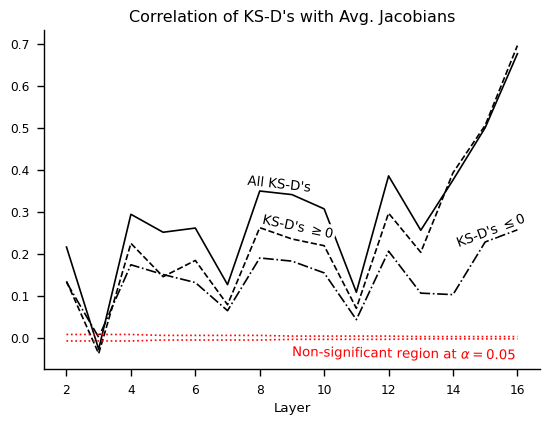

In [361]:
crits = df_corr_whole_all_imagenet['Criterion'].unique()
styles = ['solid', 'dashed', 'dashdot', 'dotted', 'dotted']
colors = ['black', 'black', 'black', 'red', 'red']

for c, s, col in zip(crits, styles, colors):
    sns.lineplot(data=df_corr_whole_all_imagenet[df_corr_whole_all_imagenet['Criterion'] == c], x='Layer', y='Correlation KS-D with Avg. Jac.', linestyle=s, color=col, err_kws={'alpha': 0.05}, legend=False, label=c)
l = plt.gca().get_lines()

# df_r_crit_fb = df_corr_whole_all_imagenet[(df_corr_whole_all_imagenet['Criterion'].str.contains('Critical')) & (df_corr_whole_all_imagenet['Network'] == 1)]
# plt.gca().fill_between(df_r_crit_fb['Layer'], -df_r_crit_fb['Correlation KS-D with Avg. Jac.'], df_r_crit_fb['Correlation KS-D with Avg. Jac.'], label='Region')

labelLines(l, align=[True, True, True, False], xvals=[8.6, 9.2, 15.2, 12.5], yoffsets=[0.02, 0.03, 0.02, -0.0425]);
# custom_lines = [Line2D([0], [0], color="black", lw=1.5, linestyle=l[0].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[1].get_linestyle()),
#                 Line2D([0], [0], color="black", lw=1.5, linestyle=l[2].get_linestyle()),
#                 ]
# plt.gca().legend(custom_lines, crits, ncols=2, loc=loc, frameon=False, title="Criterion")
plt.gca().set(ylabel='')
plt.gca().set_title("Correlation of KS-D's with Avg. Jacobians", fontsize='large')
sns.despine()

## Binary Separability

In [150]:
layers = range(15)
df_list = []
for li in layers:
    df = pd.read_csv(f"binary_separability_imagenet_val_nofolds_{li}.csv").rename(columns={"layer_name": "Layer", "neuron_idx": "Neuron", "class_idx": "Class", 'mean_balanced_acc': 'meanBA'})
    df['Network'] = 1
    df = df[['Network', 'Layer', 'Neuron', 'Class', 'meanBA']]
    df_list.append(df)
df_bin_sep_imagenet = pd.concat(df_list)
k = df_bin_sep_imagenet["Layer"].unique()
v = np.arange(len(df_bin_sep_imagenet["Layer"].unique()))+2
ln_map = {k_:v_ for k_, v_ in zip(k, v)}

df_bin_sep_imagenet["Layer"] = df_bin_sep_imagenet["Layer"].map(ln_map)
df_bin_sep_imagenet

,Network,Layer,Neuron,Class,meanBA
0,1,2,0,0,0.690641
1,1,2,0,1,0.526204
2,1,2,0,2,0.646648
3,1,2,0,3,0.769442
4,1,2,0,4,0.494782
...,...,...,...,...,...
511995,1,16,511,995,0.741645
511996,1,16,511,996,0.530557
511997,1,16,511,997,0.459216
511998,1,16,511,998,0.565289


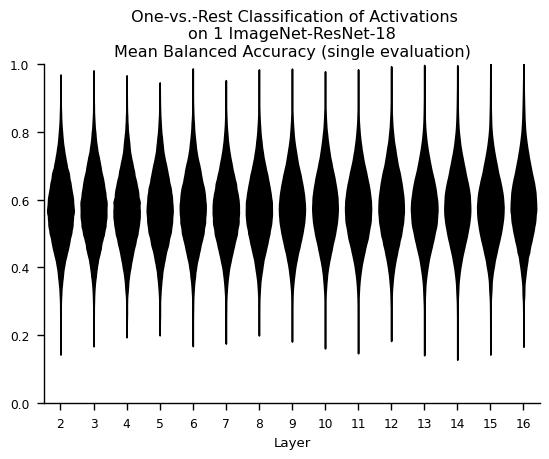

In [177]:
df = df_bin_sep_imagenet
bw = 0.05
title_suffix = "One-vs.-Rest Classification of Activations\non 1 ImageNet-ResNet-18\nMean Balanced Accuracy (single evaluation)"

g = sns.violinplot(data=df, x="Layer", y='meanBA', bw=bw, inner=None, color="black")
title_suffix = f" {title_suffix}" if title_suffix != '' else ''
g.set(ylim=(0.0, 1))
g.set_title(f"{title_suffix}", fontsize='large')
g.set(ylabel="")
sns.despine()

In [178]:
df_merged_ks_bin_sep_imagenet = pd.merge(df_ks_imagenet, df_bin_sep_imagenet, on=['Network', 'Layer', 'Neuron', 'Class'])
# df_merged_ks_bin_sep_imagenet.loc[df_merged_ks_bin_sep_imagenet[KS_NAME] <= 0]['Criterion'] = '<= 0'
df_merged_ks_bin_sep_imagenet['Criterion'] = df_merged_ks_bin_sep_imagenet[KS_NAME].apply(lambda x: "KS-D's $\\leq 0$" if x <= 0 else "KS-D's $\\geq 0$")
df_merged_ks_bin_sep_imagenet

,Network,Layer,Neuron,Class,Kolmogorov-Smirnov Difference,meanBA,Criterion
0,1,2,0,0,0.339037,0.690641,KS-D's $\geq 0$
1,1,2,0,1,-0.235088,0.526204,KS-D's $\leq 0$
2,1,2,0,2,-0.243744,0.646648,KS-D's $\leq 0$
3,1,2,0,3,-0.340359,0.769442,KS-D's $\leq 0$
4,1,2,0,4,-0.183776,0.494782,KS-D's $\leq 0$
...,...,...,...,...,...,...,...
3775995,1,16,511,995,-0.266546,0.741645,KS-D's $\leq 0$
3775996,1,16,511,996,-0.292712,0.530557,KS-D's $\leq 0$
3775997,1,16,511,997,-0.179515,0.459216,KS-D's $\leq 0$
3775998,1,16,511,998,-0.170451,0.565289,KS-D's $\leq 0$


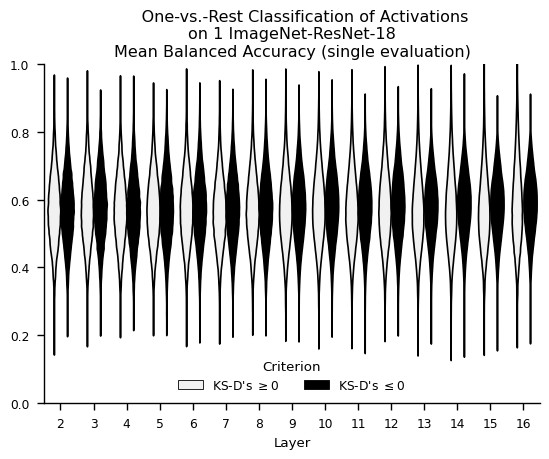

In [182]:
g = sns.violinplot(data=df_merged_ks_bin_sep_imagenet, x="Layer", y='meanBA', hue='Criterion', bw=bw, inner=None, color="black")
title_suffix = f" {title_suffix}" if title_suffix != '' else ''
g.set(ylim=(0.0, 1))
g.set_title(f"{title_suffix}", fontsize='large')
g.set(ylabel="")
g.legend(loc='lower center', title='Criterion', frameon=False, ncol=2)
sns.despine()

### Correlation with KS-D's

In [183]:
# no overall because of signs
np.corrcoef(df_ks_imagenet[KS_NAME], df_bin_sep_imagenet['meanBA']), np.corrcoef(df_ks_imagenet[df_ks_imagenet[KS_NAME] > 0][KS_NAME], df_bin_sep_imagenet[df_ks_imagenet[KS_NAME] > 0]['meanBA']), np.corrcoef(df_ks_imagenet[df_ks_imagenet[KS_NAME] < 0][KS_NAME], df_bin_sep_imagenet[df_ks_imagenet[KS_NAME] < 0]['meanBA'])

(array([[1.        , 0.02185478],
        [0.02185478, 1.        ]]),
 array([[1.        , 0.64607701],
        [0.64607701, 1.        ]]),
 array([[ 1.        , -0.59785798],
        [-0.59785798,  1.        ]]))

In [184]:
df_list = []
for crit_name, crit_op in [('\\geq', operator.ge), ('\\leq', operator.le), ('!=', operator.ne)]:
    df_ks_imagenet_crit = df_ks_imagenet[crit_op(df_ks_imagenet[KS_NAME], 0)]
    df_ks_imagenet_crit[f"{KS_NAME}_abs"] = df_ks_imagenet_crit[KS_NAME].abs()
    df_corr_crit = pd.merge(df_ks_imagenet_crit, df_bin_sep_imagenet, on=['Network', 'Layer', 'Neuron', 'Class']).sort_values(by=['Network', 'Neuron', 'Class']).groupby(['Layer'])[[f"{KS_NAME}_abs", 'meanBA']].corr()

    df_corr_crit = df_corr_crit.reset_index().iloc[:, ::2].iloc[1::2][['Layer', f"{KS_NAME}_abs"]].rename(columns={f"{KS_NAME}_abs": "Correlation KS-D's and mean BA"})
    if crit_name == '!=':
        df_corr_crit['Criterion'] = f"All KS-D's\n(abs. vals.)"
    else:
        df_corr_crit['Criterion'] = f"KS-D's ${crit_name} 0$"
    df_list.append(df_corr_crit)
df_corrs_all = pd.concat(df_list).reset_index(drop=True)

/tmp/ipykernel_29192/422079194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ks_imagenet_crit[f"{KS_NAME}_abs"] = df_ks_imagenet_crit[KS_NAME].abs()
/tmp/ipykernel_29192/422079194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ks_imagenet_crit[f"{KS_NAME}_abs"] = df_ks_imagenet_crit[KS_NAME].abs()


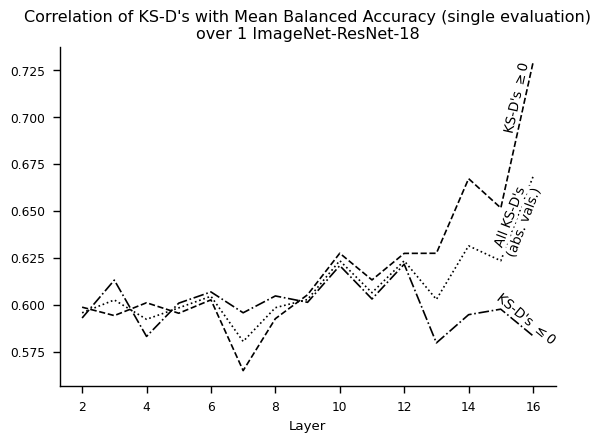

In [194]:
styles = ['dashed', 'dashdot', 'dotted']

for crit, style in zip(df_corrs_all['Criterion'].unique(), styles):
    sns.lineplot(data=df_corrs_all[df_corrs_all['Criterion'] == crit], x='Layer', y="Correlation KS-D's and mean BA", linestyle=style, color='black', label=crit, legend=False)
l = plt.gca().get_lines()

labelLines(l, xvals=[15.5, 15.8, 15.5], yoffsets=[0.02, 0.0055, -0.0008]);
plt.gca().set(ylabel='')
plt.gca().set_title("Correlation of KS-D's with Mean Balanced Accuracy (single evaluation)\nover 1 ImageNet-ResNet-18", fontsize='large')
sns.despine()

In [203]:
# DONE: check wasser shifts again.. -> less, wasser dists were better but worse than KS-Diff.
SHIFTS_NAME = "Mean Shift"

layers = range(0, 15)
df_list = []
for l in layers:
    shifts_path = f"wasser_dists/wasser_shift_attr_hist_pretrained_imagenet_afterrelu_{l}.npy"
    shifts = np.load(shifts_path, allow_pickle=True).item()
    df = pd.DataFrame.from_dict(shifts)
    df = df.unstack().reset_index().rename(columns={"level_0": "Neuron", "level_1": "Class", 0: SHIFTS_NAME})
    df["Layer"] = int(l)+2
    df["Network"] = 1
    df = df[["Network", "Layer", "Neuron", "Class", SHIFTS_NAME]]
    df_list.append(df)
df_shifts_imagenet = pd.concat(df_list)
df_shifts_imagenet

,Network,Layer,Neuron,Class,Mean Shift
0,1,2,0,0,0.074280
1,1,2,0,1,-0.056179
2,1,2,0,2,-0.072882
3,1,2,0,3,-0.117772
4,1,2,0,4,-0.057113
...,...,...,...,...,...
511995,1,16,511,995,-0.386600
511996,1,16,511,996,-0.398763
511997,1,16,511,997,-0.295552
511998,1,16,511,998,-0.234305


In [204]:
# no overall because of signs
np.corrcoef(df_shifts_imagenet[SHIFTS_NAME], df_bin_sep_imagenet['meanBA']), np.corrcoef(df_shifts_imagenet[df_shifts_imagenet[SHIFTS_NAME] > 0][SHIFTS_NAME], df_bin_sep_imagenet[df_shifts_imagenet[SHIFTS_NAME] > 0]['meanBA']), np.corrcoef(df_shifts_imagenet[df_shifts_imagenet[SHIFTS_NAME] < 0][SHIFTS_NAME], df_bin_sep_imagenet[df_shifts_imagenet[SHIFTS_NAME] < 0]['meanBA'])

(array([[1.       , 0.1299778],
        [0.1299778, 1.       ]]),
 array([[1.        , 0.29360352],
        [0.29360352, 1.        ]]),
 array([[ 1.        , -0.17216036],
        [-0.17216036,  1.        ]]))

# General

In [1]:
# DONE: i think I am confusing layers..
# KS diff and bin sep use layer_bn
# Jacobians use afterrelu

# Whats the difference? None, because `save_activations` in `find_highest_activating_images` adds a manual relu after bn1

# This makes it similar.

In [ ]:
# Interestingly, there are no negative activations... why?
# When it's a bn1 layer it applies relu afterwards.. Is this now the same as layers_afterrelu? Yes!

# Stuff to start
- [ x ] Imagenet KS-D's again and compare with old -> Not necessary
- [ x ] merge old and new wasser dist folder again
- [ x ] Binary sep for all CIFAR, compare with old for network 1
- [ x ] Binary sep for all Imagenet
    - [ x ] Plot
- [ x ] Jacobians for non-skip CIFAR
    - [ x ] Plot
- [ x ] KS-D's for non-skip CIFAR (old has wrong network order)
- [  ] Imagenet Proportion plot like CIFAR with unique criterion (if possible at all)
- [  ] Change all correlation plots that use a mean to one that correlates over everything